# Modele Seq2Seq i atencja
Poniższy notebook jest inspirowany tym tutorialem PyTorcha: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html. Zachęcam żeby zajrzeć tam po więcej informacji.

W tym notebooku będziemy próbować rozwiązać problem automatycznego tłumaczenia zdań z jednego języka naturalnego na drugi -- konkretniej z języka polskiego na angielski. Dla przykładu model otrzymujący zdanie:

> Myślę, że mnie okłamałeś

Powinien zwrócić zdanie
> I think you lied to me.



# Importy i przygotowanie danych
Poniżej znajdują się importy bibliotek potrzebnych do rozwiązania problemu a także skrypt do ładowania zbioru danych zawierającego pary zdań w języku polskim i angielskim. Poniższy kod można odpalić i schować, ale zachęcamy do zaznajomienia się z tym jak wygląda obróbka danych.


In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import string
import numpy as np
import re
import random
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!wget https://raw.githubusercontent.com/gmum/ml2022-23/master/lab/resources/eng-pol.txt

--2023-01-17 00:15:02--  https://raw.githubusercontent.com/gmum/ml2022-23/master/lab/resources/eng-pol.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5081049 (4.8M) [text/plain]
Saving to: ‘eng-pol.txt’

eng-pol.txt         100%[===================>]   4.84M  --.-KB/s    in 0.02s   

2023-01-17 00:15:02 (218 MB/s) - ‘eng-pol.txt’ saved [5081049/5081049]



Poniżej przygotowujemy klasę `Lang` która będzie służyła jako struktura do obsługiwania naszego języka (osobna dla angielskiego i polskiego w naszym przypadku). Do każdego słowa w języku przypisujemy indeks (liczbę porządkową identyfikującą słowo). Dodatkowo definiujemy trzy dodatkowe indeksy:

* 0 dla początku zdania (Start of Sentence, SOS)
* 1 dla końca zdania (End of Sentence, EOS)
* 2 dla paddingu ("pustych" wartości). Wartościami tymi będziemy wypełniać zdania w batchu tak, żeby wszystkie były równej długości -- dzięki temu łatwiej będzie zrównoleglić przetwarzanie ich na GPU.

In [4]:


SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
        self.n_words = 3 # Count SOS, EOS and PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Funkcje do normalizowania wchodzących zdań - zamieniamy Unicode na ASCII, zamieniamy wszystkie wielkie litery na małe itd.

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.replace("ł", "l")
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('eng-pol.txt', encoding='utf-8').\
        read().strip().split('\n')
    lines = lines[1:]  # Skip first line with attributions.

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[1::2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Wyrzućmy zdania które są zbyt długie (ponad 20 słów).

In [6]:
MAX_LENGTH = 20

def filterPair(p):
    return len(p[0].split(' ')) <= MAX_LENGTH and \
        len(p[1].split(' ')) <= MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Pełny proces przetwarzania danych wygląda następująco:

- Wczytujemy plik z danymi, dzielimy go na pary zdań.
- Normalizujemy tekst
- Zamieniamy zdania w listy słów.




In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(pairs[0])
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('pol', 'eng', True)
print("Przykładowe pary zdań:")
for _ in range(3):
    print(random.choice(pairs))

Reading lines...
['sprobujmy cos .', 'let s try something .']
Read 59749 sentence pairs
Trimmed to 59404 sentence pairs
Counting words...
Counted words:
eng 29246
pol 11953
Przykładowe pary zdań:
['poznalam toma zanim skonczylam szkole srednia ale mary poznalam dopiero wiele lat pozniej .', 'i met tom before i graduated from high school but didn t meet mary until many years later .']
['ta strona zostala stworzona specjalnie dla osob ktore chca sie uczyc jezykow obcych .', 'this website was created specifically for people who want to learn foreign languages .']
['to byl najgorszy dzien w moim jedenastoletnim zyciu .', 'this has been the most awful day in my eleven year old life .']


Na koniec definiujemy jeszcze funkcje, które pozwolą nam zamienić zdania w tensory, które nasza sieć będzie w stanie zrozumieć.

In [8]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


def pad_sequences(data_batch):
    pl_batch, en_batch = [], []
    for pl_sentence, en_sentence in data_batch:
        pl_batch += [pl_sentence]
        en_batch += [en_sentence]
    pl_batch = pad_sequence(pl_batch, padding_value=PAD_token, batch_first=True)
    en_batch = pad_sequence(en_batch, padding_value=PAD_token, batch_first=True)
    return pl_batch, en_batch

def prepare_dataset(batch_size):
    rng = np.random.RandomState(567)
    indices = np.arange(len(pairs))
    rng.shuffle(indices)
    train_indices = indices[:int(len(pairs) * 0.8)]
    test_indices = indices[int(len(pairs) * 0.8):]
    train_pairs = list(pairs[idx] for idx in train_indices)
    test_pairs = list(pairs[idx] for idx in test_indices)
    tensor_train_pairs = [tensorsFromPair(pairs[idx]) for idx in train_indices]
    tensor_test_pairs = [tensorsFromPair(pairs[idx]) for idx in test_indices]
    reference_translation = test_pairs

    # Output in natural language?

    train_loader = DataLoader(tensor_train_pairs, batch_size=batch_size,
                            shuffle=True, collate_fn=pad_sequences)
    test_loader = DataLoader(tensor_test_pairs, batch_size=batch_size,
                            shuffle=True, collate_fn=pad_sequences)
    return train_pairs, test_pairs, train_loader, test_loader

# Model Seq2Seq



W tym celu wykorzystany rekurencyjne sieci neuronowe (RNN-y), które poznaliśmy na poprzednich zajęciach. Konkretniej zbudujemy za ich pomocą model Sequence to Sequence (Seq2Seq), w której wykorzystamy dwie sieci rekurencyjne:
1. Enkoder, który będzie przyjmował kolejno słowa ze zdania wejściowego i kompresował informacje o nich w swoim stanie ukrytym.
2. Dekoder, który będzie generował kolejne słowa w języku docelowym. 

![seq2seq](https://docs.chainer.org/en/stable/_images/seq2seq.png)
Źródło: https://docs.chainer.org/

## Funkcje pomocnicze i ewaluacyjne

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def predict(encoder, decoder, inputs, targets=None, max_len=MAX_LENGTH):
    batch_size = inputs.size(0)

    encoder_outputs, encoder_hidden = encoder(inputs)

    decoder_input = torch.tensor([[SOS_token]] * batch_size, device=device)
    decoder_hidden = encoder_hidden
    decoder_output, decoder_attention = decoder(
        decoder_input,
        decoder_hidden,
        targets=targets,
        max_len=max_len,
        encoder_outputs=encoder_outputs)
    return decoder_output, decoder_attention

def translate(encoder, decoder, sentence, show_attention=True):
    inputs = tensorFromSentence(input_lang, sentence).unsqueeze(0).cuda()
    decoder_output, decoder_attention = predict(encoder, decoder, inputs)

    decoded_words = []
    for word in decoder_output[0]:
        top_word = word.argmax(-1).item()
        decoded_words.append(output_lang.index2word[top_word])
        if top_word == EOS_token:
            break

    if decoder_attention is not None and show_attention:
        # [out_words, in_words]
        att = decoder_attention.cpu().detach().numpy()
        att = att[0, :len(decoded_words), :]
        fig, ax = plt.subplots()

        im = ax.imshow(att, vmin=0, vmax=1)
        ax.xaxis.tick_top()
        ax.set_xticklabels([''] + sentence.split(' ') +
                        ['EOS'], rotation=90)
        ax.set_yticklabels([''] + decoded_words)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)

        fig.colorbar(im, cax=cax, orientation='vertical')
        
        ax.tick_params(axis='both', which='major', labelsize=12)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.show()

    return decoded_words

def batch_translate(encoder, decoder, batch):
    decoder_output, decoder_attention = predict(encoder, decoder, batch)

    predicted_sentences = []

    # TODO: potentially paralellize?
    for batch_idx in range(len(batch)):
        predicted_words = []
        for word in decoder_output[batch_idx]:
            top_word = word.argmax(-1).item()
            if top_word == EOS_token:
                break
            predicted_words.append(output_lang.index2word[top_word])

        predicted_sentences.append(predicted_words)

    return predicted_sentences

def dataset_translate(encoder, decoder, loader):
    predicted_sentences = []
    reference_sentences = [] 
    for batch_in, batch_out in loader:
        translated = batch_translate(encoder, decoder, batch_in)
        predicted_sentences.extend(translated)

        # TODO: move to a separate file?
        reference_words = []
        for sentence_idx, sentence in enumerate(batch_out):
            decoded_sentence = []
            for word in sentence:
                if word.item() == EOS_token:
                    break
                decoded_sentence.append(output_lang.index2word[word.item()])
            reference_sentences.append(decoded_sentence)
    
    return predicted_sentences, reference_sentences


def translate_randomly(encoder, decoder, pairs, n=10):
    # TODO: reuse translate_given_pairs
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = translate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

def translate_given_pairs(encoder, decoder, pairs):
    for pair in pairs:
        print('>', pair[0])
        print('=', pair[1])
        output_words = translate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def plot_results(bleus, losses):
    sns.set_style('whitegrid')

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    axes[0].plot(np.arange(len(bleus)), bleus)
    axes[0].set_xlabel("Epoka")
    axes[0].set_ylabel("BLEU")
    axes[1].plot(np.arange(len(losses)), losses)
    axes[1].set_xlabel("Epoka")
    axes[1].set_ylabel("Koszt na zbiorze treningowym")

## Pętla trenująca

In [10]:
def train(encoder, decoder, lr=0.01, batch_size=256, teacher_forcing_ratio=0.5, epochs_num=100, clipping=1.0):

    # Prepare dataset, loss functions, optimizer
    train_pairs, test_pairs, train_loader, test_loader = prepare_dataset(batch_size)

    criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

    encoder.cuda()
    decoder.cuda()

    bleus = []
    train_losses = []

    for epoch in range(epochs_num + 1):

        # Training
        epoch_train_loss = 0.
        for in_batch, out_batch in train_loader:
            in_batch, out_batch = in_batch.cuda(), out_batch.cuda()

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
        
            teacher_inputs = out_batch if random.random() < teacher_forcing_ratio else None
        
            decoder_output, decoded_attention = predict(
                encoder, decoder, in_batch,
                targets=teacher_inputs,
                max_len=out_batch.size(1)
            )

            loss = criterion(decoder_output.transpose(1, 2), out_batch)
            
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(encoder.parameters(), clipping)
            nn.utils.clip_grad_norm_(decoder.parameters(), clipping)

            encoder_optimizer.step()
            decoder_optimizer.step()

            epoch_train_loss += loss.item()

        # Evaluation
        if epoch % 1 == 0:
            with torch.no_grad():
                print("=" * 25, "Translation test", "=" * 25)
                translate_randomly(encoder, decoder, test_pairs, n=5)

            pred_sentences, ref_sentences = dataset_translate(encoder, decoder, test_loader)
            bleu_val = bleu_score(pred_sentences, [[sentence] for sentence in ref_sentences])
            print("=" * 25, f"BLEU: {bleu_val}", "=" * 25)
            bleus += [bleu_val]

        mean_train_loss = epoch_train_loss / len(train_loader)
        train_losses += [mean_train_loss]
        print(f"Epoch: {epoch}. Train loss: {mean_train_loss}")
    return bleus, train_losses

# Zadanie 1 - Dekoder w Seq2Seq (4 pkt.)

W tym zadaniu należy zaimplementować dekoder z modelu Seq2Seq. Kod enkodera jest dostępny poniżej i ma Państwu ułatwić odpowiednie zaimplementowanie dekodera.



Dekoder otrzymuje na wejściu następujące argumenty:
- `input` - tensor o wymiarach `[batch_size, 1]` zawierający słowo `<BOS>`. Powinno być podane w pierwszym kroku wykonywania dekodera.
- `hidden` - ostatnia reprezentacja ukryta z enkodera .
- `targets` - `None` albo `torch.tensor` o wymiarach `[batch_size, seq_len]` zawierający indeksy słów w języku docelowym. Jeżeli jest podany to należy zaimplementować teacher forcing na jego podstawie.
- `max_len` - Długość sekwencji, którą mamy zwrócić.
- `encoder_outputs` - w tym zadaniu ten argument należy zignorować, przyda się dopiero w kolejnym zadaniu.

Dekoder ma zwrócić dwie zmienne:
- `output` - tensor o wymiarach `[batch_size, max_len, vocab_size]` reprezentujące logity, które po zaaplikowaniu softmaksa (co będzie zrobione już poza dekoderem) będą reprezentowały prawdopodobieństwa słów przewidzianych przez nasz dekoder.
- `attention_weights` - w tym zadaniu należy zawsze zwracać `None`.

Architektura głowy klasyfikacyjnej jest dowolna, natomiast zalecamy sieć z jedną warstwą ukrytą: `[hidden_size, hidden_size, vocab_size]` i aktywacją tanh.


**HINT 1**: Warto pamiętać o argumencie `batch_first=True` przy definiowaniu RNN-a.

**HINT 2**: W enkoderze mogliśmy użyć jednego wywołania klasy GRU, jako że od razu mieliśmy wszystkie wejścia (słowa języka wejściowego). W przypadku dekodera nie jest to możliwe, jako że wejściem w kroku `t+1` jest wyjście z kroku `t`. Oznacza to że prawdopodobnie potrzebna będzie pętla `for`.

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn_cell = nn.GRU(embedding_size, hidden_size, batch_first=True)

    def forward(self, input):
        embedded = self.embedding(input)
        output, hidden = self.rnn_cell(embedded)
        return output, hidden
x=torch.tensor([])

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn_cell = nn.GRU(embedding_size, hidden_size, batch_first = True)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, vocab_size),
        )

    def forward(self, input, hidden, targets=None, max_len=None, encoder_outputs=None):
      batch_size = input.shape[0]
      outputs = []
      for i in range(0, max_len):
        embedded = self.embedding(input)
        output, hidden = self.rnn_cell(embedded, hidden)
        output = self.head(output)
        outputs += [output]
        if targets is not None:
          input = targets[:, i].reshape(batch_size, 1)
        else:
          input = output.argmax(-1).detach()
      output = torch.cat(outputs, 1)
      return output, None

========================= Translation test =========================
> tom wyszedl o piec minut za wczesnie .
= tom left five minutes early .
< tom is to tom . EOS

> nie wierze w przypadek .
= i don t believe in coincidence .
< i m t know . EOS

> cisza narasta jak nowotwor .
= silence grows like cancer .
< i m to to . EOS

> co najbardziej lubisz jesc do czerwonego wina ?
= what s your favorite food to eat with red wine ?
< do you you ? ? EOS

> w lodowce jest troche mleka .
= there s some milk in the fridge .
< the is a is a lot . EOS

========================= BLEU: 0.012612135659355234 =========================
Epoch: 0. Train loss: 5.382056410594653
========================= Translation test =========================
> tomowi trudno odmowic .
= tom isn t easy to say no to .
< tom needs to be a . EOS

> mezczyzni i kobiety potrzebuja siebie nawzajem .
= men and women need each other .
< the police was the the the the . EOS

> stracilem swiadomosc .
= i lost consciousness .
< i hav

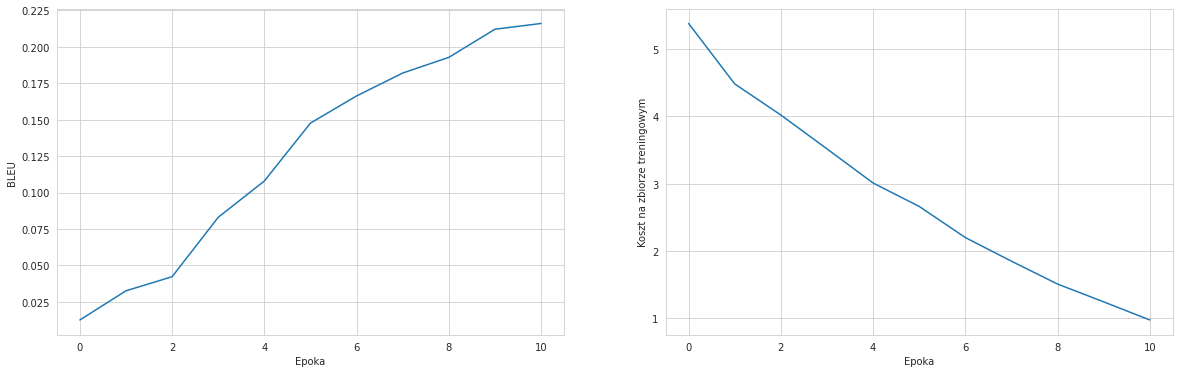

In [21]:
hidden_size = 1024
embedding_size = 512
lr = 1e-3

encoder = EncoderRNN(input_lang.n_words, embedding_size, hidden_size).to(device)
decoder = DecoderRNN(output_lang.n_words, embedding_size, hidden_size).to(device)

bleus, losses = train(encoder, decoder, batch_size=512, lr=lr, epochs_num=10, clipping=0.1)
plot_results(bleus, losses)

# Zadanie 2 - Atencja w RNN-ach (3 pkt.)

![seq2seq z dekoderem](https://www.researchgate.net/profile/Chandan_Reddy6/publication/329464533/figure/fig3/AS:701043021197314@1544153089772/An-attention-based-seq2seq-model.ppm)

Źródło: https://github.com/google/seq2seq

W tym zadaniu należy napisać kod nowego dekodera, który ma działać podobnie jak dekoder w poprzednim zadaniu, ale jednocześnie ma wykorzystywać mechanizm atencji.

W normalnym dekoderze, w kroku `t` wejściem do komórki GRU (pomijamy tutaj przekazywanie stanu ukrytego) była wyłącznie zembeddowana reprezentacja $\bar{y}_t$. W dekoderze z atencją na wejściu podawna będzie konkatenacja tego wektora oraz specjalnego wektora $z_t$ stworzonego na podstawie wyjść z enkodera: $\tilde{h}_t = [\bar{y}_t, z_t]$. 

Wektor $z_t$ jest pozyskiwany za pomocą mechanizmu atencji. Intuicyjnie chcielibyśmy w nim zebrać informacje z enkodera, które będą najistotniejsze przy dekodowaniu aktualnego słowa. Przyjmijmy, że mamy funkcję alignmentu $a(h, e)$, która jest nam w stanie powiedzieć jak bardzo podobne do siebie są stan ukryty dekodera $h$ oraz reprezentacja słowa $e$.

Wtedy 

$$
\begin{align}
w_i &= \frac{ \exp(a(h, e_i)) }{\sum_{j} \exp(a(h, e_j))} \\
z_t &= \sum_i e_i \cdot w_i
\end{align}
$$


W naszym wypadku funkcja alignmentu $a(h, e)$ ma być siecią neuronową z dwoma warstwami o kolejnych wymiarach: `[2 * hidden_size, hidden_size, 1]` i aktywacją tanh po pierwszej warstwie.

Argumenty wejściowe i wyjściowe z dekodera są takie same jak w poprzednim z zadaniu z wyjątkiem:
- Tym razem na wejściu otrzymujemy tensor `encoder_outputs` o wymiarach `[batch_size, encoder_seq_len, hidden_size]`. To są reprezentacje $e_i$, które należy wykorzystać w mechanizmie atencji.
- Tym razem na wyjściu `attention_weights` powinno być tensorem o wymiarach `[batch_size, decoder_seq_len, encoder_seq_len]` zawierającym wagi $w_i$. **HINT:** wartości tego tensora powinny się sumować do jedynki na ostatnim wymiarze.

In [41]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(AttnDecoderRNN, self).__init__()
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn_cell = nn.GRU(embedding_size + hidden_size, hidden_size, batch_first = True)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, vocab_size),
        )
        self.a = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, input, hidden, targets=None, max_len=None, encoder_outputs=None):
      batch_size = input.shape[0]
      outputs = []
      seq_att_weights = []
      for i in range(0, max_len):
        hidden_to_cat = hidden.transpose(0, 1).repeat(1, encoder_outputs.size(1), 1)
        alignments = self.a(torch.cat([hidden_to_cat, encoder_outputs], dim=2))
        w = torch.softmax(alignments, -1)
        seq_att_weights += w
        z = (encoder_outputs * w).sum(1).unsqueeze(1)

        embedded = self.embedding(input)
        input = torch.cat([embedded, z], dim=2)

        
        output, hidden = self.rnn_cell(input, hidden)
        output = self.head(output)
        outputs += [output]
        if targets is not None:
          input = targets[:, i].reshape(batch_size, 1)
        else:
          input = output.argmax(-1).detach()
      output = torch.cat(outputs, 1)
      seq_att_weights = torch.stack(seq_att_weights, 1)
      return output, seq_att_weights
      #jakoś działa, bo bleu rośnie, loss maleje, ale coś się źle rysują te heatmapy

========================= Translation test =========================
> krok do tylu prosze .
= please step back .


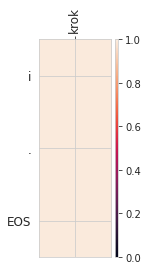

< i . EOS

> zrobie to tak szybko jak bede mial czas .
= i ll do it as soon as i have time .


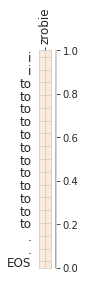

< i i to to to to to to to to to to to to . . EOS

> poczytam ksiazke gdy bedziesz spala .
= i ll read a book while you re sleeping .


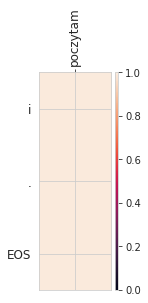

< i . EOS

> mozesz raz strzelic .
= you get one guess .


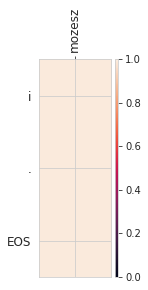

< i . EOS

> zasluzyl na nazywanie go najlepszym politykiem europy .
= he deserves to be called the best politician in europe .


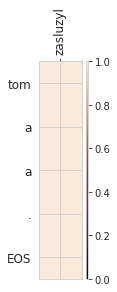

< tom a a . EOS

========================= BLEU: 0.0 =========================
Epoch: 0. Train loss: 5.653840090638848
========================= Translation test =========================
> nikt tam nie mieszka .
= nobody lives there .


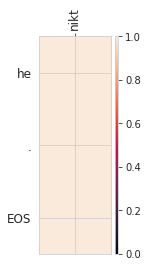

< he . EOS

> nowy kelner powinien sobie lepiej radzic .
= the new waiter should be much more competent .


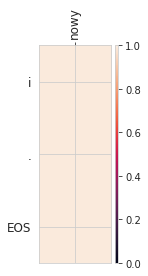

< i . EOS

> ile osob o tym wie ?
= how many people know about this ?


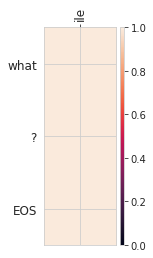

< what ? EOS

> mary pomaga kazdemu kto ja poprosi .
= mary helps anybody who asks her .


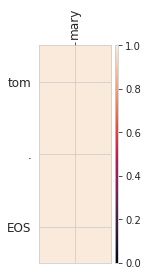

< tom . EOS

> chcemy tylko zadac mu kilka pytan na temat tego co zrobil w ostatni weekend .
= we just want to ask him a few questions about what he did last weekend .


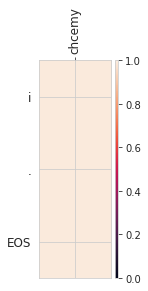

< i . EOS

========================= BLEU: 0.000805359857622534 =========================
Epoch: 1. Train loss: 5.138868829255463
========================= Translation test =========================
> rozumiem ze wczoraj rozmawiales z tomem .
= i understand you had a little talk with tom .


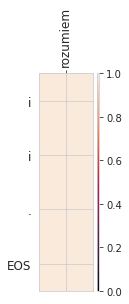

< i i . EOS

> tom uderzyl johna w zoladek .
= tom punched john in the stomach .


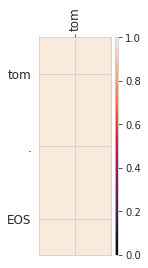

< tom . EOS

> chyba warto sprobowac prawda ?
= it s worth a try right ?


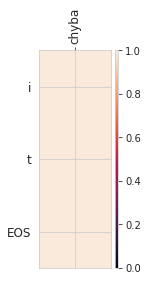

< i t EOS

> jack zbiera znaczki .
= jack collects stamps .


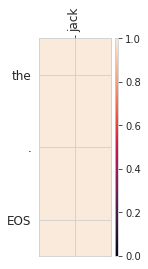

< the . EOS

> dzwoniles juz do nich ?
= have you called them yet ?


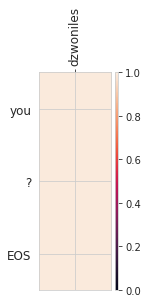

< you ? EOS

========================= BLEU: 0.005075886202084729 =========================
Epoch: 2. Train loss: 4.771039347494802
========================= Translation test =========================
> co bedzie gdyby mu sie nie powiodlo ?
= what if he should fail ?


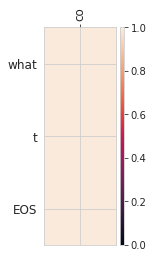

< what t EOS

> to jest zatrwazajace .
= this is creepy .


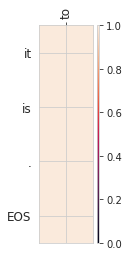

< it is . EOS

> ten rodzaj wiedzy specjalistycznej ma niewiele wspolnego z zyciem codziennym .
= this kind of specialized knowledge has very little to do with daily life .


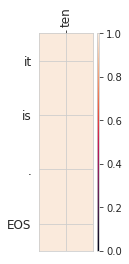

< it is . EOS

> obiecal tego nie mowic .
= he promised not to say it .


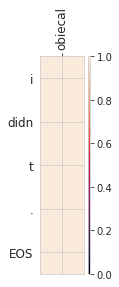

< i didn t . EOS

> tom probuje .
= tom tries .


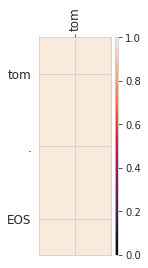

< tom . EOS

========================= BLEU: 0.031015179206397358 =========================
Epoch: 3. Train loss: 4.3537662516358075
========================= Translation test =========================
> co robiles w szpitalu ?
= what were you doing at the hospital ?


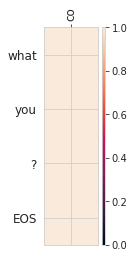

< what you ? EOS

> denerwuje mnie to .
= it makes me nervous .


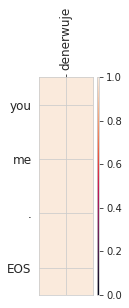

< you me . EOS

> wez tamto .
= grab that .


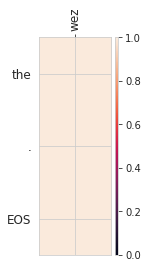

< the . EOS

> nigdy nie palilem .
= i have never smoked .


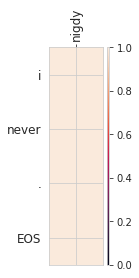

< i never . EOS

> musimy zaraz pogadac .
= we need to chat soon .


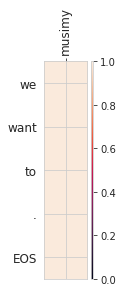

< we want to . EOS

========================= BLEU: 0.017780547961592674 =========================
Epoch: 4. Train loss: 3.8965450820102485
========================= Translation test =========================
> tom podzielil sie ze mna obiadem .
= tom shared his lunch with me .


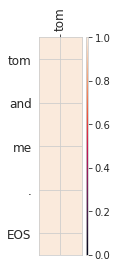

< tom and me . EOS

> moja siostra widziala to na wlasne oczy .
= my sister saw it with her own eyes .


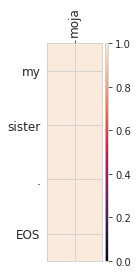

< my sister . EOS

> mozliwe .
= it is possible .


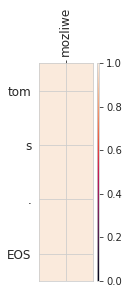

< tom s . EOS

> zachorowala na grype .
= she is down with influenza .


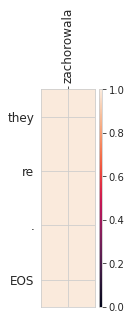

< they re . EOS

> przypisy sa na dole strony .
= the footnotes are at the bottom of the page .


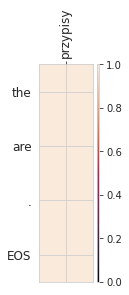

< the are . EOS

========================= BLEU: 0.07074356466277544 =========================
Epoch: 5. Train loss: 3.484554680444861
========================= Translation test =========================
> mam prawa .
= i have rights .


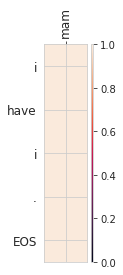

< i have i . EOS

> czekamy od ponad dwoch miesiecy .
= we ve been waiting for over two months .


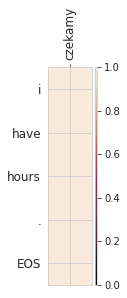

< i have hours . EOS

> wenus jest planeta .
= venus is a planet .


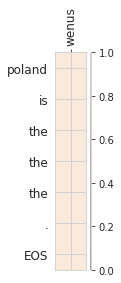

< poland is the the the . EOS

> z oslem za kierownica ilosc koni pod maska nie ma znaczenia .
= the horsepower of a car matters not with a donkey in control .


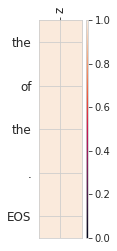

< the of the . EOS

> on jest szefem .
= he s the boss .


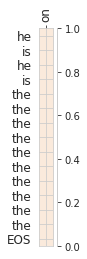

< he is he is the the the the the the the the the the EOS

========================= BLEU: 0.09070847172735562 =========================
Epoch: 6. Train loss: 3.194365193766932
========================= Translation test =========================
> fizyka nie interesuje mnie zupelnie .
= i m not the least bit interested in physics .


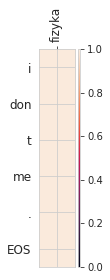

< i don t me . EOS

> nie wykonuj gwaltownych ruchow .
= don t make abrupt moves .


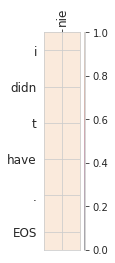

< i didn t have . EOS

> nie mialem wystarczajacych dowodow .
= i didn t have enough proof .


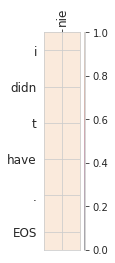

< i didn t have . EOS

> umarl smutna smiercia .
= he died a sad death .


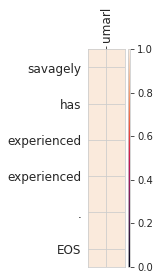

< savagely has experienced experienced . EOS

> wtedy sie wszystko zaczelo .
= that s when it all started .


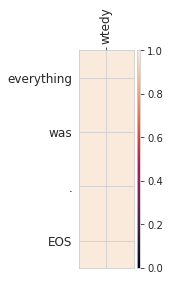

< everything was . EOS

========================= BLEU: 0.11152381352700289 =========================
Epoch: 7. Train loss: 2.8390004942494054
========================= Translation test =========================
> twoj zegarek jest na biurku .
= your watch is on the desk .


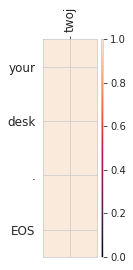

< your desk . EOS

> juz skonczylem czytac te ksiazke .
= i have already finished reading this book .


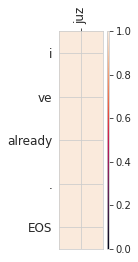

< i ve already . EOS

> dlaczego nie chcesz tego robic ?
= why don t you want to do that ?


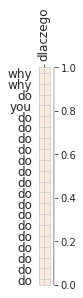

< why why do you do do do do do do do do do do do do do do do do

> pracuje dorywczo jako dostawca pizzy .
= my part time job is delivering pizzas .


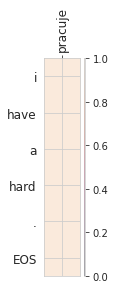

< i have a hard . EOS

> oskarzyla mnie o nieuczciwosc .
= she charged me with dishonesty .


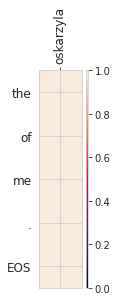

< the of me . EOS

========================= BLEU: 0.12793933369289298 =========================
Epoch: 8. Train loss: 2.5158657181647515
========================= Translation test =========================
> tom nie pojdzie dzisiaj do pracy .
= tom won t go to work today .


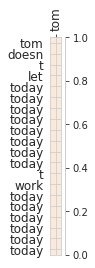

< tom doesn t let today today today today today today today today t work today today today today today today

> po dlugim namysle zlodziej zdecydowal sie przyznac .
= after much thought the thief decided to confess .


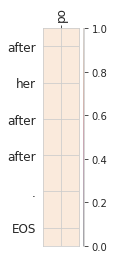

< after her after after . EOS

> czy jestem w ciazy ?
= am i pregnant ?


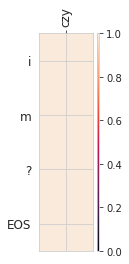

< i m ? EOS

> dom zapadl sie tydzien pozniej .
= the house fell down one week later .


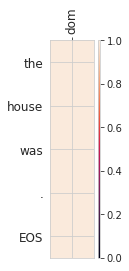

< the house was . EOS

> to jest dostepne ?
= is it accessible ?


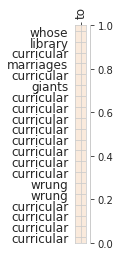

< whose library curricular marriages curricular giants curricular curricular curricular curricular curricular curricular curricular curricular wrung wrung curricular curricular curricular curricular

========================= BLEU: 0.1477293183974649 =========================
Epoch: 9. Train loss: 2.177661503514936
========================= Translation test =========================
> spal godzine .
= he slept an hour .


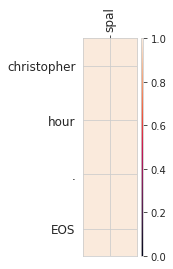

< christopher hour . EOS

> tom zgasil lampke na stoliku nocnym .
= tom turned off the lamp on the nightstand .


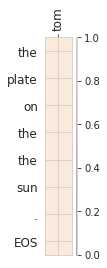

< the plate on the the sun . EOS

> kupilem to w zeszlym roku .
= i bought that last year .


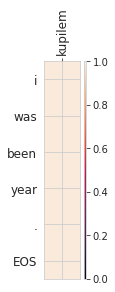

< i was been year . EOS

> przeczytaj te ksiazke .
= read this book .


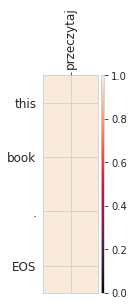

< this book . EOS

> kazdy zna nasze nazwiska .
= everyone knows our names .


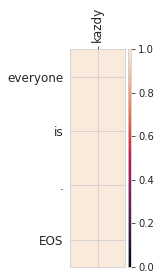

< everyone is . EOS

========================= BLEU: 0.16150728390422803 =========================
Epoch: 10. Train loss: 1.9051255320989957


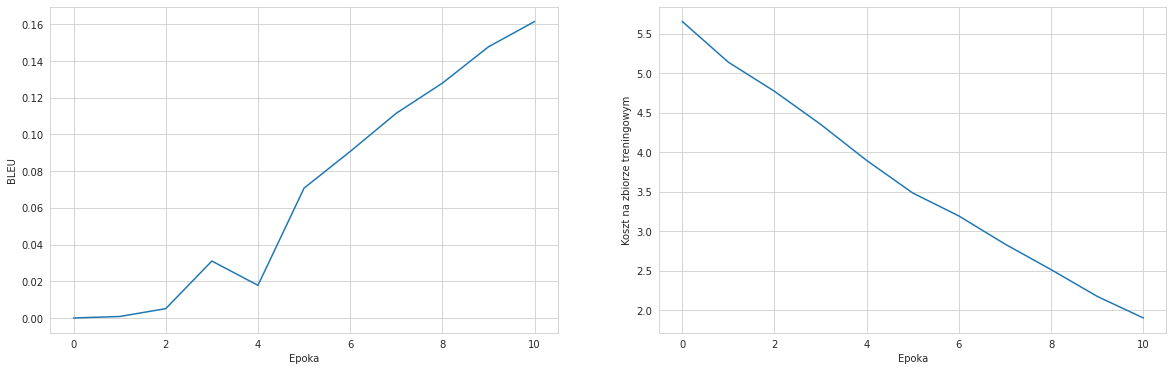

In [42]:
hidden_size = 1024
embedding_size = 512
lr = 1e-3
clip = 0.1
encoder = EncoderRNN(input_lang.n_words, embedding_size, hidden_size).to(device)
decoder = AttnDecoderRNN(output_lang.n_words, embedding_size, hidden_size).to(device)

bleus, losses = train(encoder, decoder, lr=lr, batch_size=512, epochs_num=10, clipping=0.1)
plot_results(bleus, losses)

# Powiązana literatura

* [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
* [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

## Przydatne tutoriale

* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* https://github.com/bentrevett/pytorch-seq2seq
* https://github.com/gmum/AppliedDL2020/tree/master/Week%207 - materiały z kursu Applied Deep Learning prowadzonego w semestrze letnim


# Zadanie dodatkowe: Transformer (7 pkt.)

Na podstawie pracy [Attention is All You Need](https://arxiv.org/abs/1706.03762) oraz strony [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention) zaimplementuj transformera działającego na powyższym zadaniu tłumaczenia z polskiego na angielski.

![transformer](http://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png)

In [43]:
!pip install happytransformer  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [44]:
from happytransformer import  HappyTextToText

In [45]:
happy_tt  = HappyTextToText("T5", "Helsinki-NLP/opus-mt-pl-en")

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/309M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/835k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/785k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [46]:
from happytransformer import TTSettings
args = TTSettings(min_length=0)
result = happy_tt.generate_text("Witaj świecie", args=args)
print(result)

TextToTextResult(text='Hello, world.')
